In [10]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_absolute_percentage_error as MAPE
import matplotlib.pyplot as plt
import pydotplus
import pickle
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from xgboost import XGBRegressor, XGBRFRegressor
from IPython.display import clear_output
from matplotlib import style
style.use('ggplot')

In [2]:
df = pd.read_excel('../final_data.xlsx')

df=df.iloc[:,1:]
df_org = df.copy()
df.head(3)

,Duration,Resource Cost,Fixed Cost,Cost/Hour,Variable Cost,Total Cost,Actual Cost
0,3.0,2400.0,0.0,0.0,0.0,2400.0,2400.0
1,1.0,800.0,0.0,0.0,0.0,800.0,800.0
2,1.0,440.0,0.0,0.0,0.0,440.0,440.0


In [50]:
#Standardization or Normalization
for column in df.columns:
    df[column] = MinMaxScaler().fit_transform(np.array(df[column]).reshape(-1,1))
df.head(10)

In [3]:
# setting x and y
X = df.drop('Actual Cost',axis=1)
# X = df[['Duration','Total Cost']]
y = df['Actual Cost']
# preparing test and train
X_train,X_test,y_train,y_test = train_test_split(
    X,y,test_size=0.2,random_state=41
)

In [16]:
def generate_metrics(model):
    cr_score = -cross_val_score(model,X_train,y_train,scoring='neg_mean_absolute_percentage_error',cv=3)
    model.fit(X_train,y_train)
    train_r2 = model.score(X_train,y_train)
    test_r2 = model.score(X_test,y_test)
    y_pred = model.predict(X_test)
    error_MAE = MAE(y_pred,y_test)
    error_MSE = MSE(y_test,y_pred)
    error_MAPE = MAPE(y_test,y_pred)
    return cr_score,train_r2,test_r2,error_MAE,error_MSE,error_MAPE
def print_metrics(cr,tr_R,ts_R,mae,mse,mape):
    print("Cross-Validation-Score:"+str(np.average(cr)))
    print("MAE: "+str(mae))
    print('MSE: '+str(mse))
    print("Train R2: "+ str(tr_R))
    print("Test R2: "+ str(ts_R))
    print("MAPE: "+ str(mape))
def plot_mape(x,cr,mape,x_label):
    min_x = x[mape.index(min(mape))]
    min_y = min(mape)
    min_cr_x = x[cr.index(min(cr))]
    min_cr_y = min(cr)
    fig = plt.figure()
    plt.title('XGBoost HyperParameter OPT')
    plt.xlabel(x_label)
    plt.ylabel("error")
    plt.plot(x,cr,c='green',label='Cross-Val')
    plt.plot(x,mape,c='red',label='Test-MAPE')
    plt.plot(min_x,min_y,'oy',markersize=12)
    plt.annotate("("+str(round(min_x,2))+', '+str(round(min_y,3))+")",xy=(min_x,min_y))
    # plt.plot(min_cr_x,min_cr_y,'oy',markersize=12)
    # plt.annotate("("+str(round(min_cr_x,2))+', '+str(round(min_cr_y,3))+")",xy=(min_cr_x,min_cr_y))
    plt.legend()
    plt.savefig('pics_mape/'+x_label+'.png')
    plt.show()

****** 20/20 ******
0.0
287.81103403433195


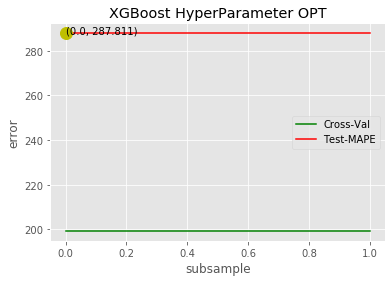

In [33]:
n_estimators = np.linspace(2,100,20,endpoint=True,dtype=int)
max_depth = np.linspace(10,30,10,endpoint=True,dtype=int)
learning_rate = np.linspace(0,1,20)
reg_alpha = np.linspace(0,6.0e7,20)
colsample_bytree = np.linspace(0,1,20)
colsample_bylevel = np.linspace(0,1,20)
colsample_bynode = np.linspace(0,1,20)
reg_lambda = np.linspace(1.0e12,1.0e15,10)
scale_pos_weight = np.linspace(1.0e4,1.0e5,20)
max_delta_step = np.linspace(1.0e-1,0.2,20)
min_child_weight = np.linspace(0,1,10)
booster = ['gbtree','gblinear','dart']
# gamma = np.linspace(0,1000000,20)
# subsample = np.linspace(0,1,20)
parameter = n_estimators
name_parameter = 'n_estimators'
couunter = 1
cr_list = []
mape_list = []
for i in parameter:
# --------------------------
    xg_reg = XGBRFRegressor(
        n_estimators=i,
        random_state=41,
        n_jobs=-2
    )
# -------------------------- For Tuning
    cr,tr_R,ts_R,mae,mse,mape = generate_metrics(xg_reg)
    cr_list.append(np.average(cr))
    mape_list.append(mape)
    if couunter % 10 == 0:
        clear_output(wait=True)
    print("****** " + str(couunter)+'/'+str(len(parameter))+" ******")
    couunter+=1
print(parameter[mape_list.index(min(mape_list))])
print(min(mape_list))
plot_mape(parameter,cr_list,mape_list,x_label=name_parameter)
# print_metrics(cr,tr_R,ts_R,mae,mse,mape)

### Base Model (with no hyper parameters)
#### with two attrs
Cross-Validation-Score:6565.782321586107 <br>
MAE: 7377.721373220953 <br>
MSE: 1061464136.2264417 <br>
Train R2: 0.9970477632396384 <br>
Test R2: 0.8297132915736618 <br>
#### with all attrs
Cross-Validation-Score:7428.833721072005
MAE: 5071.731755954239
MSE: 569814709.2298542
Train R2: 0.9974438828582196
Test R2: 0.8346174026152794
#### BEST n_estimators = 11
#### MAE = 4900
#### BEST max_depth = 8
#### MAE = 4767
#### BEST learning_rate = 0.2663316582914573
#### MAE = 4623.631200798262
#### Reg_alpha
133.06613226452907
MAE: 4577.087092328461
#### Reg_lambda
11.623246492985972
4442.908024873111
### Model After Exploratory Parameter Tuning
### Final Model with all attrs
n_estimators=11,random_state=41,max_depth=8,
                      learning_rate=0.2663316582914573,
                      reg_alpha=133.06613226452907,
                      reg_lambda =11.63265306122449
Cross-Validation-Score:6768.117147546978
MAE: 4442.52554416961
MSE: 289463014.31045765
Train R2: 0.901789473869717
Test R2: 0.9159864700260604

## Trying to find the best hyper paramteters

In [115]:
# Randomized Search
n_estimators = np.linspace(2,200,50,endpoint=True,dtype=int)
max_depth = np.linspace(10,40,20,endpoint=True,dtype=int)
learning_rate = np.linspace(0,1,10)
reg_alpha = [0,56842105.26]
reg_lambda = [667000000000000,1]
# max_delta_step = [0.1]
scale_pos_weight = np.linspace(1.0e4,1.0e5,10)
colsample_bytree = np.linspace(0,1,10)
colsample_bylevel = np.linspace(0,1,10)
colsample_bynode = np.linspace(0,1,10)
booster = ['gbtree','gblinear','dart']
random_state = [41]
random_grid = {
    'n_estimators':n_estimators,
    'max_depth':max_depth,
    'learning_rate':learning_rate,
    'reg_alpha':reg_alpha,
    'reg_lambda':reg_lambda,
    # 'max_delta_step':max_delta_step,
    'scale_pos_weight':scale_pos_weight,
    'colsample_bytree':colsample_bytree,
    'colsample_bylevel':colsample_bylevel,
    'colsample_bynode':colsample_bynode,
    'booster':booster,
    'random_state':random_state
}
xg_reg = XGBRegressor()
random_search = RandomizedSearchCV(
    estimator=xg_reg,
    param_distributions=random_grid,
    n_iter=500,
    cv=3,
    random_state=42,
    n_jobs=-3,
    verbose=2,
    scoring='neg_mean_absolute_percentage_error')
random_search.fit(X_train,y_train)
print("done")

Fitting 3 folds for each of 500 candidates, totalling 1500 fits
[17:59:00] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


done


In [116]:
-random_search.best_score_

0.9459185509089215

In [117]:
random_search.best_params_

{'scale_pos_weight': 100000.0,
 'reg_lambda': 1,
 'reg_alpha': 56842105.26,
 'random_state': 41,
 'n_estimators': 10,
 'max_depth': 27,
 'learning_rate': 0.5555555555555556,
 'colsample_bytree': 0.6666666666666666,
 'colsample_bynode': 0.2222222222222222,
 'colsample_bylevel': 0.6666666666666666,
 'booster': 'gblinear'}

In [118]:
y_pred = random_search.best_estimator_.predict(X_test)
MAPE(y_pred,y_test)

0.6920062855659879

In [119]:
# Grid Search
n_estimators = [10,100,7]
max_depth = [27,30,6]
learning_rate = [0.55,0,0.3]
reg_alpha = [0,56842105.26]
reg_lambda = [667000000000000,1,0]
max_delta_step = [0.1,0.7]
scale_pos_weight = [100000,1]
colsample_bytree = [0.66,0.84,1]
colsample_bylevel = [0.66,0.84,1]
colsample_bynode = [0.22,1]
booster = ['gbtree','gblinear','dart']
random_state = [41]
search_grid = {
    'n_estimators':n_estimators,
    'max_depth':max_depth,
    'learning_rate':learning_rate,
    'reg_alpha':reg_alpha,
    'reg_lambda':reg_lambda,
    'max_delta_step':max_delta_step,
    'scale_pos_weight':scale_pos_weight,
    'colsample_bytree':colsample_bytree,
    'colsample_bylevel':colsample_bylevel,
    'colsample_bynode':colsample_bynode,
    'booster':booster,
    'random_state':random_state
}
xg_reg = XGBRegressor(random_state=41)
search = GridSearchCV(
    estimator=xg_reg,
    param_grid=search_grid,
    cv=3,
    n_jobs=-3,
    verbose=2,
    scoring='neg_mean_absolute_percentage_error')
search.fit(X_train,y_train)
print("done")

Fitting 3 folds for each of 34992 candidates, totalling 104976 fits
[18:16:53] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, max_delta_step, max_depth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


done


In [120]:
-search.best_score_

0.9467564790744802

In [121]:
search.best_params_

{'booster': 'gblinear',
 'colsample_bylevel': 0.66,
 'colsample_bynode': 0.22,
 'colsample_bytree': 0.66,
 'learning_rate': 0.55,
 'max_delta_step': 0.1,
 'max_depth': 27,
 'n_estimators': 10,
 'random_state': 41,
 'reg_alpha': 56842105.26,
 'reg_lambda': 1,
 'scale_pos_weight': 100000}

In [122]:
y_pred = search.best_estimator_.predict(X_test)
MAPE(y_pred,y_test)

0.693109333461706

#FINAL MODEL

In [124]:
mae = []
mape = []
mse = []
for i in range(1,20):
    print('****'+str(i)+'****')
    X = df.drop('Actual Cost',axis=1)
    y = df['Actual Cost']
    X_train,X_test,y_train,y_test = train_test_split(
        X,y,test_size=0.2)
    xg_reg = search.best_estimator_
    xg_reg.fit(X_train,y_train)
    y_pred = xg_reg.predict(X_test)
    clear_output(wait=True)
    mae.append(MAE(y_test,y_pred))
    mse.append(MSE(y_test,y_pred))
    mape.append(MAPE(y_test,y_pred))
print(np.average(mae))
print(np.average(mse))
print(np.average(mape))

4111.632716395066
331360564.1560205
0.9393211980625621


the mean mae after running for 100 times: 6258.430085218316

In [106]:
MAE_MSP = MAE(df['Actual Cost'],df['Total Cost'])
print("MAE MSP:")
print(MAE_MSP)
MSE_MSP = MSE(df['Actual Cost'],df['Total Cost'])
print("MSE MSP:")
print(MSE_MSP)

MAE MSP:
4371.532003104657
MSE MSP:
536755019.1048717
